In [1]:
!pip install sentence-transformers langchain faiss-cpu openai pinecone-client

In [2]:
# OPENAI_API_KEY=""

In [3]:
import sys
sys.path.append("..")
from vekta_testa import runner, utils

In [4]:
import pandas as pd
import json
from langchain.docstore.document import Document

# Dataset adapted from: https://www.kaggle.com/datasets/juhibhojani/house-price
data = pd.read_csv('indian_real_estate.csv')

# Grab the value we will be searching for out of the dataset
chosenIndex = data.iloc[284]
clean_value = {key: value for key, value in chosenIndex.to_dict().items() if value is not None and not pd.isna(value)}
clean_doc = Document(page_content=json.dumps(clean_value), metadata={})

# Shuffle the dataset to mix cities
shuffled = data.sample(frac=1).reset_index(drop=True)

properties = [clean_doc]
for index, row in shuffled.iterrows():
    # Clean out the empty data
    clean_row = {key: value for key, value in row.to_dict().items() if value is not None and not pd.isna(value)}
    json_string = json.dumps(clean_row)
    doc = Document(page_content=json_string, metadata={})
    properties.append(doc)

In [5]:
properties[0]

Document(page_content='{"Unnamed: 0": 284, "Index": 284, "Title": "2 BHK Ready to Occupy Flat for sale in Swastik Alps Thane West", "Description": "Thane West, Thane has an appealing 2 BHK flat for sale with various amenities. Situated in the excellent Swastik Alps township. The flat enjoys a prime location. This is a desirable apartment for resale. You can buy this ready to move flat in Thane West at a reasonable price of INR 1.20 Cr. You will find it semi-furnished.", "Price (in rupees)": 10573.0, "Location": "thane", "Status": "Ready to Move", "Furnishing": "Semi-Furnished", "Society": "Swastik Alps", "Bathroom": "2", "Super Area": "1135 sqft"}', metadata={})

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

tableModel = HuggingFaceEmbeddings(model_name="deepset/all-mpnet-base-v2-table", encode_kwargs=encode_kwargs )
table_index = FAISS.from_documents(properties[:2000], tableModel)

In [7]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import FAISS

model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

bgeModel = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-base-en", model_kwargs=model_kwargs, encode_kwargs=encode_kwargs)
faiss_index_bge = FAISS.from_documents(properties[:2000], bgeModel)

In [8]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS

oaiEmbeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
faiss_index_openai = FAISS.from_documents(properties[:2000], oaiEmbeddings)
# faiss_index_openai.similarity_search_with_score('apartment', k=1001)[0]

In [9]:
import json
def find_id(entries, target_id):
    for index, (entry, score) in enumerate(entries):
        if str(entry['Index']) == target_id:
            # print('id found')
            return index
    return -1

def find_id_pinecone(entries, target_id):
    for index, (entry, score) in enumerate(entries):
        # print('-', json.loads(entry.page_content)['Index'], '<', target_id, json.loads(entry.page_content)['Index'] == target_id)
        if str(json.loads(entry.page_content)['Index']) == target_id:
            # print('id found')
            return index
    return -1

In [10]:
# Update values from langchain to vekta_testa format
def post_processor(scenario, scored_values):
    processor_results = []
    for index, (entry, score) in enumerate(scored_values):
        value = json.loads(entry.page_content)
        processor_results.append((value, score))
    return processor_results

In [12]:
results = runner.run_vecta_tests(
    [
        runner.EmbeddingIndex(
            index_name='openai',
            search_function=lambda scenario: faiss_index_openai.similarity_search_with_score(scenario, k=900),
            find_result=lambda values, target: find_id(values, target),
            post_processor=lambda scenario, scored_values: post_processor(scenario, scored_values)
        ),
        runner.EmbeddingIndex(
            index_name='deepset/all-mpnet-base-v2-table',
            search_function=lambda scenario: table_index.similarity_search_with_score(scenario, k=900),
            find_result=lambda values, target: find_id_pinecone(values, target)
        ),
        runner.EmbeddingIndex(
            index_name='BAAI/bge-large-en',
            search_function=lambda scenario: faiss_index_bge.similarity_search_with_score(scenario, k=900),
            find_result=lambda values, target: find_id_pinecone(values, target)
        ),
    ],
    [
        runner.Testcase(
            case_id='0-control',
            scenario="kimchi"
        ),
        runner.Testcase(
            case_id='1-exact',
            scenario="Thane has an appealing 2 BHK flat for sale with various amenities. Situated in the excellent Swastik Alps township."
        ),
        runner.Testcase(
            case_id='2-partial',
            scenario="Thane has an appealing 2 BHK flat for sale with various amenities. It's located in the exquisite township near the mountains."
        ),
        runner.Testcase(
            case_id='3-other-words',
            scenario='Offers a charming two bedroom apartment available, equipped with numerous features. Located in the prime Swastik Heights community.'
        ),
        runner.Testcase(
            case_id='4-location',
            scenario='Apartment in Swastik Alps town'
        ),
        runner.Testcase(
            case_id='5-negative',
            scenario='apartment in the alps, without a terrace'
        ),
        runner.Testcase(
            case_id='6-price-beds',
            scenario='apartment for under 11000 rupees with 2 bedrooms'
        )
    ],
    '284'
)

Starting test -  0-control
Starting test -  1-exact
Starting test -  2-partial
Starting test -  3-other-words
Starting test -  4-location
Starting test -  5-negative
Starting test -  6-price-beds


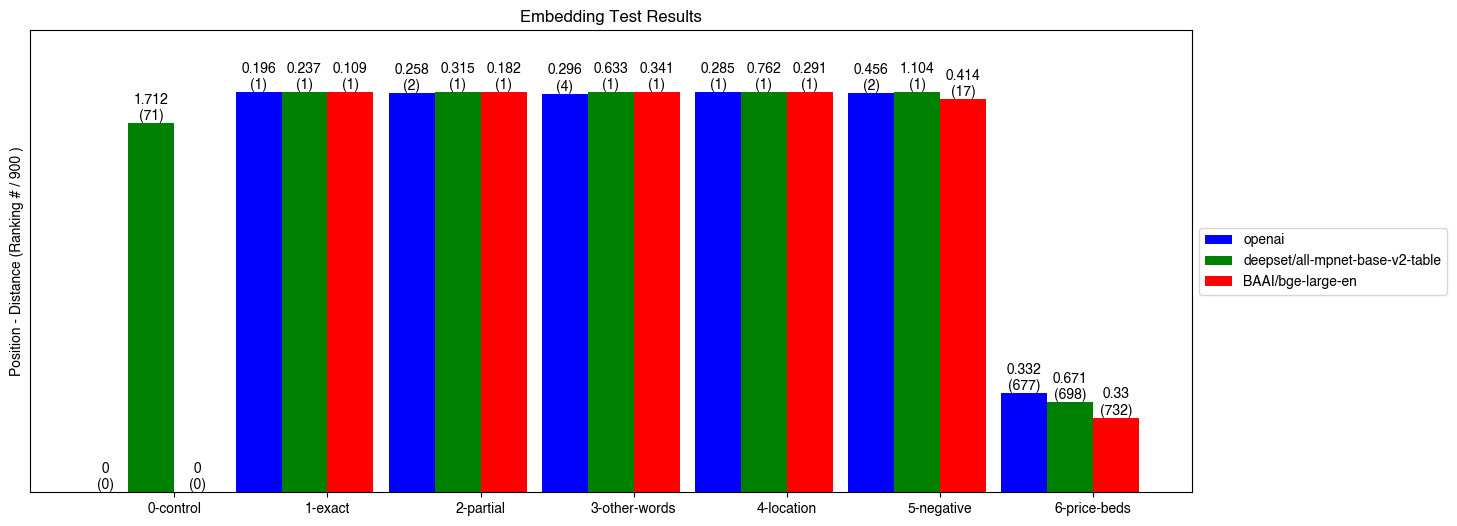

In [14]:
from vekta_testa.graph import plot_results

plot_results(results, {
        'openai': 'b',
        'deepset/all-mpnet-base-v2-table': 'g',
        'BAAI/bge-large-en': 'r',
    },
    900
)

In [15]:
results['0-control'][1]['all_results'][899]

(Document(page_content='{"Unnamed: 0": 9280, "Index": 9280, "Title": "2 BHK Ready to Occupy Flat for sale in Pooja Apartment Maninagar", "Description": "Have a look at this immaculate 2 BHK flat for sale in Maninagar, Ahmedabad. It enjoys an excellent location within the\\u00a0Pooja Apartment. This is one of the best properties available for resale. This apartment in one of the significant areas of Maninagar is ready to move, and can be purchased at the best price of INR 65 Lac. It is a unfurnished apartment.", "Price (in rupees)": 6878.0, "Location": "ahmedabad", "Square Footage": "105 sqyrd", "Status": "Ready to Move", "Furnishing": "Unfurnished", "facing": "East", "overlooking": "Main Road", "Society": "Pooja Apartment", "Bathroom": "2", "Balcony": "2", "Ownership": "Freehold"}', metadata={}),
 1.8341149)